# Mood-RL Ordinal Regression

## Section 1: Motivating the model

## Section 2: Model fitting

In [1]:
import os, pystan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()

## Extract and prepare stimulus presentation data.
X = data[['M1','M2']].values.reshape(N,B,T,2)

## Extract and prepare choice data. 
## Missing values coded as -1.
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )

## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

m2 = ratings.loc[np.logical_and(ratings.Block==2, ratings.Trial==0),'Rating'].values / 4
m2 = np.where(m2==-1, -0.99, np.where(m2==1, 0.99, m2))

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, m2=m2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot subjects.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Make plots dir.
    plots_dir = os.path.join(out_dir, 'plots')
    if not os.path.isdir(plots_dir): os.makedirs(plots_dir)

    ## Iteratively plot.
    for i in np.arange(fit['N']):

        ## Plot and save.
        fig, axes = plot_subject(fit, i)
        fig.savefig(os.path.join(plots_dir, 'subj_%s.png' %(i+1)), dpi=180)
        plt.close('all')
        
    print('Done.')

<IPython.core.display.Javascript object>

## Section 3: Model comparisons

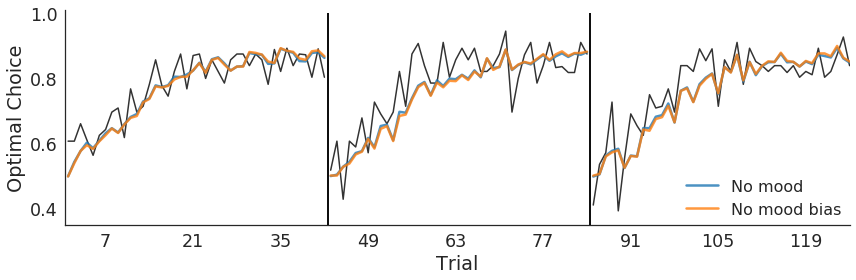

In [2]:
from scripts.plotting import plot_behavior
from scripts.utilities import model_comparison

## Define parameters.
models = ['moodRL_centered_no_mood', 'moodRL_centered_no_mood_bias']
colors = sns.color_palette(n_colors=len(models))
labels = ['No mood', 'No mood bias']

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [True,False], colors, labels):
    plot_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=16)

sns.despine()
plt.tight_layout()

In [3]:
## Compute model comparison.
model_comparison(*models, on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 6224
WAIC[2] = 6225
Diff	= -0.72 (3.51)


In [4]:
## Compute model comparison.
model_comparison(*models, on='m', verbose=True);

Model comparison
----------------
WAIC[1] = 13
WAIC[2] = -124
Diff	= 137.70 (37.11)


In [5]:
## Compute model comparison.
model_comparison(*models, on='both', verbose=True);

Model comparison
----------------
WAIC[1] = 6238
WAIC[2] = 6101
Diff	= 136.98 (37.74)


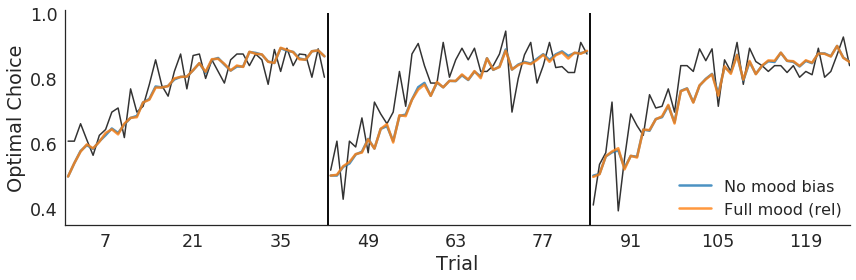

In [6]:
## Define parameters.
models = ['moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_rel', 
          'moodRL_centered_full_mood_glob']
colors = sns.color_palette(n_colors=len(models))
labels = ['No mood bias', 'Full mood (rel)', 'Full mood (global)']

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [True,False], colors, labels):
    plot_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=16)

sns.despine()
plt.tight_layout()

In [7]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_rel', on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 6225
WAIC[2] = 6221
Diff	= 3.64 (3.58)


In [8]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_rel', on='m', verbose=True);

Model comparison
----------------
WAIC[1] = -124
WAIC[2] = -122
Diff	= -2.42 (3.06)


In [9]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_rel', on='both', verbose=True);

Model comparison
----------------
WAIC[1] = 6101
WAIC[2] = 6099
Diff	= 1.21 (4.71)


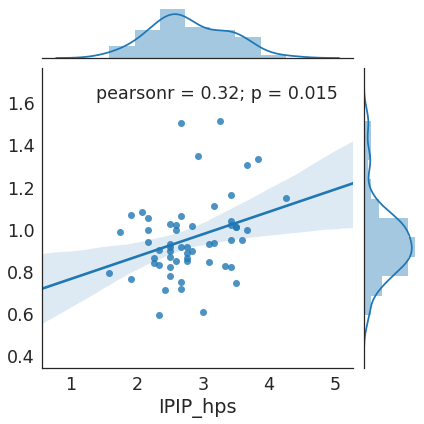

In [10]:
from scripts.utilities import load_fit
fit = load_fit('moodRL_centered_full_mood_rel')
sns.jointplot(metadata.IPIP_hps, np.median(fit['f'], axis=0), kind='reg')

In [11]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_glob', on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 6225
WAIC[2] = 6217
Diff	= 7.95 (5.04)


In [12]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_glob', on='m', verbose=True);

Model comparison
----------------
WAIC[1] = -124
WAIC[2] = -132
Diff	= 7.83 (3.67)


Is this because of the likelihood or the complexity term?

In [13]:
## Compute model comparison.
model_comparison('moodRL_centered_no_mood_bias', 'moodRL_centered_full_mood_glob', on='both', verbose=True);

Model comparison
----------------
WAIC[1] = 6101
WAIC[2] = 6085
Diff	= 15.78 (6.24)


In [42]:
## Compute model comparison.
model_comparison('moodRL_centered_full_mood_rel', 'moodRL_centered_full_mood_glob', on='both', verbose=True);

Model comparison
----------------
WAIC[1] = 6099
WAIC[2] = 6085
Diff	= 14.57 (4.67)


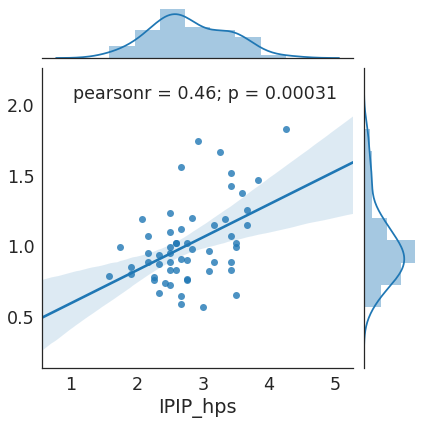

In [14]:
from scripts.utilities import load_fit
fit = load_fit('moodRL_centered_full_mood_glob')
sns.jointplot(metadata.IPIP_hps, np.median(fit['f'], axis=0), kind='reg')

In [40]:
from scripts.utilities import HDIofMCMC

bounds = np.apply_along_axis(HDIofMCMC, 0, fit['f'], credMass=0.8)
print(np.invert(np.logical_xor(*(bounds > 1))).sum())

bounds = np.apply_along_axis(HDIofMCMC, 0, fit['f'], credMass=0.95)
print(np.invert(np.logical_xor(*(bounds > 1))).sum())

2
0


## Simulations

In [ ]:
from scripts.simulations import MoodyAgent, slot_machine_game

n_sim = 1000
n_subj = 3
n_mood = 3
n_trials = 42

## Preallocate space.
Y = np.zeros((n_sim, n_subj, n_mood, n_trials))

agents = [MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=1.0),
          MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=0.67),
          MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=1.5)]

for i in np.arange(n_sim):
    
    ## Simulate game.
    X, R = slot_machine_game(n_trials=n_trials, reward=1)
    
    for j, agent in enumerate(agents): 
    
        for k, mood in enumerate([0,0.9,-0.9]):

            Y[i,j,k], _ = agent.simulate(X,R,Q=0,M=mood)        
            
Y = Y.mean(axis=0)

fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
for i, ax, mood in zip(range(3),axes,[0,0.9,-0.9]):
    
    for arr, label in zip(Y[:,i,:], [1,0.67,1.5]):
        
        ax.plot(arr, label='%0.2f' %label)
        
    ax.set(title='M = %0.1f' %mood)
    ax.legend(loc=4, borderpad=0, labelspacing=0)
    ax.grid(axis='y', alpha=0.25, zorder=0)
    
sns.despine()
plt.tight_layout()